In [2]:
from snowflake import connector
import pathlib
from dotenv import dotenv_values
import pandas as pd
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
# Get the parent directory of the current working directory
script_path = pathlib.Path.cwd().parent
config = dotenv_values(f"{script_path}/configuration.env")

In [6]:
# Create the connection URL with proper formatting
connection_url = (
    f"snowflake://{config.get('snowflake_user')}:{config.get('snowflake_password')}@"
    f"{config.get('snowflake_account')}/"
    f"{config.get('snowflake_database')}/"
    f"{config.get('snowflake_schema')}?"
    f"warehouse={config.get('snowflake_warehouse')}&"
    f"role={config.get('snowflake_role')}"
)

# Create the SQLAlchemy engine with disable_ocsp_checks set to True
engine = create_engine(
    connection_url,
    connect_args={"disable_ocsp_checks": True}
)

In [4]:
# Load data with pandas
# table_name = "REVIEW"
# query = f"SELECT * FROM {table_name};"
# df = pd.read_sql(query, engine)

# df.head()

In [7]:
# Load data with pandas
query = """
SELECT
    f.review_id AS review_id,
    f.date_submitted_id AS review_date_id,
    d.day_of_week_name AS review_day_of_week,
    d.cal_mon_name AS review_month_name,
    d.cal_month AS review_month_number,
    d.cal_year AS review_year,
    f.verified AS review_verified,
    c.customer_name AS customer_name,
    d.cal_mon_name AS flight_month_name,
    d.cal_month AS flight_month_number,
    d.cal_year AS flight_year,
    CONCAT(d.cal_mon_name, '-', d.cal_year) AS flight_month_year,
    c.nationality AS customer_country,
    a.aircraft_model AS aircraft_model,
    a.aircraft_manufacturer AS aircraft_manufacturer,
    a.seat_capacity AS aircraft_seat_capacity,
    f.seat_type AS review_seat_type,
    ol.city AS origin_city,
    ol.airport as origin_airport,
    dl.city AS destination_city,
    dl.airport AS destination_airport,
    tl.city AS transit_city,
    tl.airport AS transit_airport,
    f.seat_comfort AS review_seat_comfort,
    f.cabin_staff_service AS review_cabin_staff_service,
    f.food_and_beverages AS review_food_beverage,
    f.ground_service AS review_ground_service,
    f.inflight_entertainment AS review_inflight_entertainment,
    f.value_for_money AS review_value_for_money,
    f.review_text AS review_text
FROM 
    fct_review f
JOIN 
    dim_date d ON f.date_submitted_id = d.date_id
JOIN 
    dim_customer c ON f.customer_id = c.customer_id
JOIN 
    dim_location ol ON f.origin_location_id = ol.location_id
JOIN 
    dim_location dl ON f.destination_location_id = dl.location_id
JOIN 
    dim_location tl ON f.transit_location_id = tl.location_id
JOIN 
    dim_aircraft a ON f.aircraft_id = a.aircraft_id
WHERE 
    f.date_submitted_id IS NOT NULL;
"""
df = pd.read_sql(query, engine)

df.head()


,review_id,review_date_id,review_day_of_week,review_month_name,review_month_number,review_year,review_verified,customer_name,flight_month_name,flight_month_number,...,destination_airport,transit_city,transit_airport,review_seat_comfort,review_cabin_staff_service,review_food_beverage,review_ground_service,review_inflight_entertainment,review_value_for_money,review_text
0,1,2015-08-27,Thu,August,8,2015,False,Nick Lester-Davis,August,8,...,LHR,Unknown,Unknown,3.0,5.0,4.0,4.0,NaN,4,The British Airways plane I flew on from Larna...
1,2,2015-08-28,Fri,August,8,2015,False,Karen Hibbert,August,8,...,BOS,London,LHR,1.0,4.0,1.0,1.0,1.0,1,Did this same trip last summer with delays etc...
2,3,2015-08-28,Fri,August,8,2015,False,Neil Oakshott,August,8,...,PHX,Unknown,Unknown,1.0,2.0,1.0,3.0,1.0,1,The sad decline of our national flag carrier s...
3,4,2015-08-29,Sat,August,8,2015,False,Daniel Cook,August,8,...,GVA,Unknown,Unknown,2.0,4.0,3.0,3.0,NaN,3,I have been flying with British Airways on the...
4,7,2015-08-29,Sat,August,8,2015,False,Ste Morris,August,8,...,LHR,Unknown,Unknown,2.0,1.0,2.0,1.0,NaN,3,I didn't really know what to expect from this ...


In [6]:
# df.to_csv("../data/review.csv", index=False)

Number of verified reviews: 1325
Number of columns: 30
Number of normal reviews: 3000
Number of columns: 30


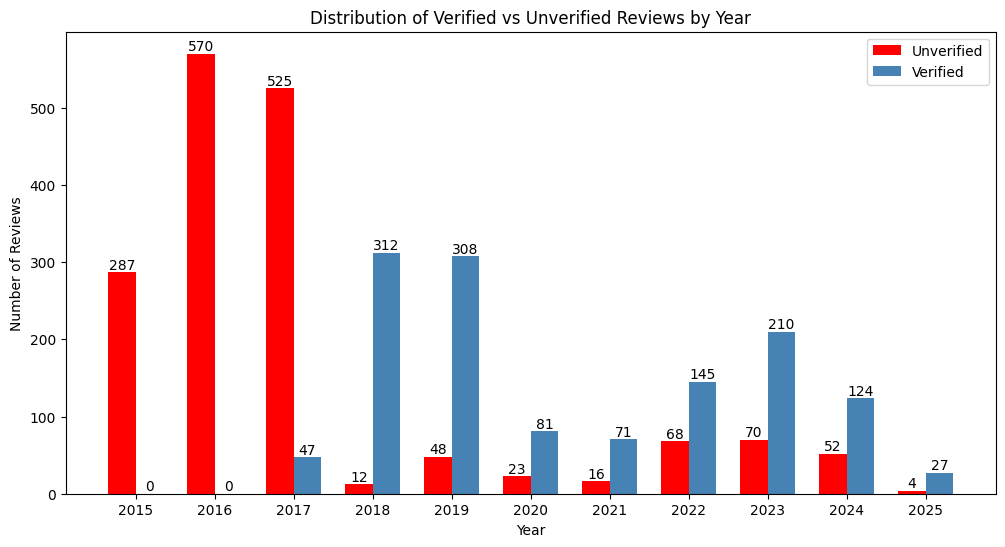

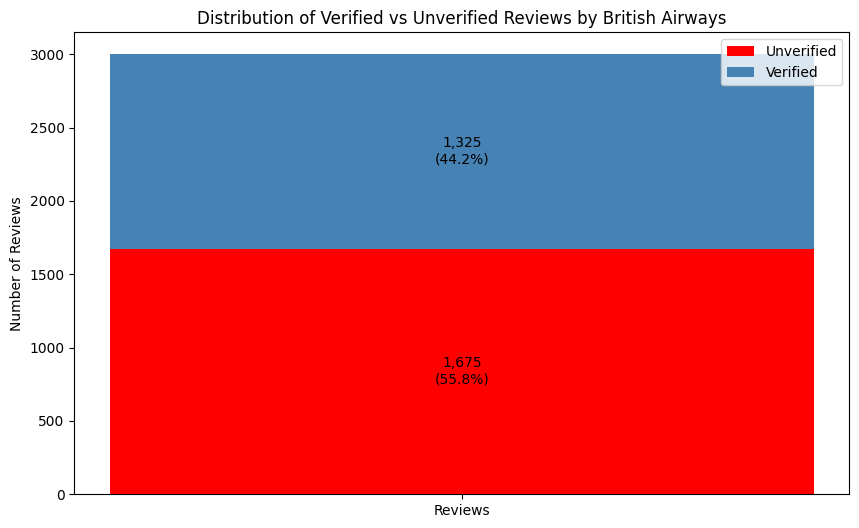

In [7]:
# EDA for master data 
# Filter for verified reviews only
df_verified = df[df['review_verified'] == True]

# Group by year and review_verified, count occurrences
yearly_verification = df.groupby(['review_year', 'review_verified']).size().unstack(fill_value=0)

# Rename columns for clarity
yearly_verification.columns = ['Unverified', 'Verified']

# Reset index to make review_year a column
yearly_verification = yearly_verification.reset_index()

yearly_verification.head()
# Create a side-by-side bar plot
plt.figure(figsize=(12, 6))

# Set the width of each bar and positions of the bars
width = 0.35
x = np.arange(len(yearly_verification))

# Create bars
plt.bar(x - width/2, yearly_verification['Unverified'], width, label='Unverified', color='red')
plt.bar(x + width/2, yearly_verification['Verified'], width, label='Verified', color='steelblue')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Verified vs Unverified Reviews by Year')
plt.xticks(x, yearly_verification['review_year'])
plt.legend()

# Add value labels on the bars
for i in x:
    plt.text(i - width/2, yearly_verification['Unverified'][i], 
             f'{yearly_verification["Unverified"][i]}', 
             ha='center', va='bottom')
    plt.text(i + width/2, yearly_verification['Verified'][i], 
             f'{yearly_verification["Verified"][i]}', 
             ha='center', va='bottom')


# Print dimensions of the filtered dataframe
print(f"Number of verified reviews: {df_verified.shape[0]}")
print(f"Number of columns: {df_verified.shape[1]}")

print(f"Number of normal reviews: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Create a bar chart showing distribution of verified vs unverified reviews

# Calculate counts
verified_counts = df['review_verified'].value_counts()

# Create stacked bar chart
plt.figure(figsize=(10, 6))
plt.bar(['Reviews'], [verified_counts[False]], label='Unverified', color='red')
plt.bar(['Reviews'], [verified_counts[True]], bottom=[verified_counts[False]], label='Verified', color='steelblue')

# Add labels and title
plt.ylabel('Number of Reviews')
plt.title('Distribution of Verified vs Unverified Reviews by British Airways')
plt.legend()

# Add value labels on the bars
total = verified_counts.sum()
plt.text('Reviews', verified_counts[False]/2, f'{verified_counts[False]:,}\n({verified_counts[False]/total:.1%})', 
         ha='center', va='center')
plt.text('Reviews', verified_counts[False] + verified_counts[True]/2, 
         f'{verified_counts[True]:,}\n({verified_counts[True]/total:.1%})', 
         ha='center', va='center')

plt.show()


<Figure size 1200x600 with 0 Axes>

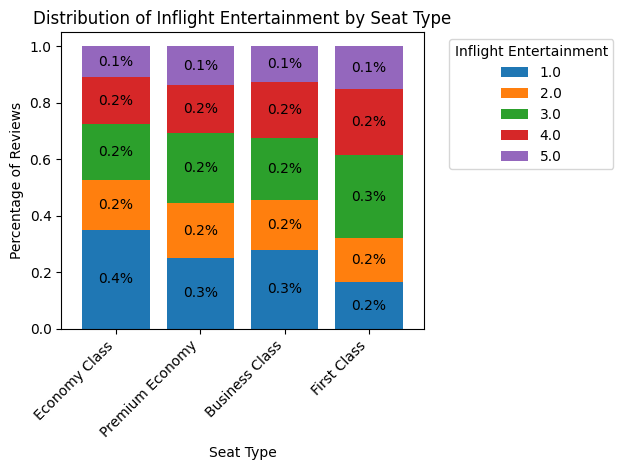

In [8]:
def plot_seat_type_distribution(df, value_col, title_suffix=''):
    """
    Create a stacked bar plot showing the distribution of ratings by seat type.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe containing the review data
    value_col : str
        The column name for the values to be analyzed
    title_suffix : str, optional
        Additional text to append to the plot title
        
    Returns:
    --------
    A plot of the distribution of ratings by seat type
    """
    # Calculate percentages for each seat type and rating
    seat_value_pcts = df.groupby('review_seat_type')[value_col].value_counts(normalize=True).unstack()

    # Reorder seat types
    seat_order = ['Economy Class', 'Premium Economy', 'Business Class', 'First Class']
    seat_value_pcts = seat_value_pcts.reindex(seat_order)

    # Create stacked bar plot
    plt.figure(figsize=(12, 6))
    ax = seat_value_pcts.plot(kind='bar', stacked=True, width=0.8)

    # Set plot title and labels
    plt.title(f'Distribution of {value_col.replace("review_", "").replace("_", " ").title()} by Seat Type{title_suffix}')
    plt.xlabel('Seat Type')
    plt.ylabel('Percentage of Reviews')
    plt.legend(title=f'{value_col.replace("review_", "").replace("_", " ").title()}', 
              bbox_to_anchor=(1.05, 1), 
              loc='upper left')

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')

    # Add percentage labels on the bars
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%', label_type='center')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

# Example usage:
plot_seat_type_distribution(df, 'review_inflight_entertainment')


Possible questions for investigation:
1. Does the cabin crew service consistent among different seat type in a flight?
2. What mostly contribute to the rating of 1 for value for money?
3. Seat comfort largely due to different type of airplane?
4. Food and beverage rating due to cabin class and flight distance
5. Ground service due to departure and arrival airports?
6. Inflight entertainment due to type of aircraft? - Possibly answer the question should British Airways allocate more resources in purchasing any specific type of aircrafts 
7. Sanity check for relationship between ratings of seat comfort, food and beverage, ground service, inflight entertainment and value for money (linear regression)

<Figure size 1200x600 with 0 Axes>

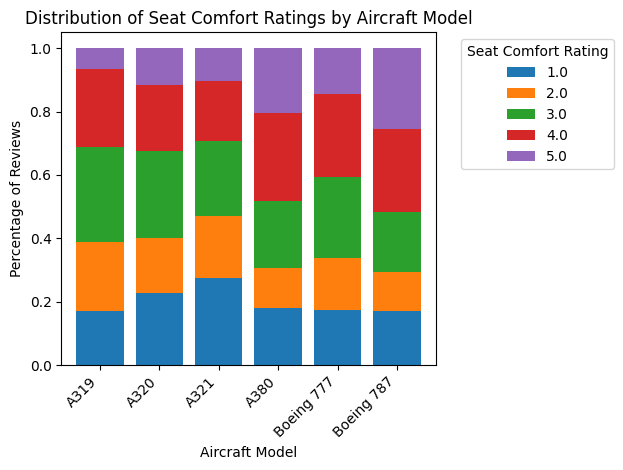

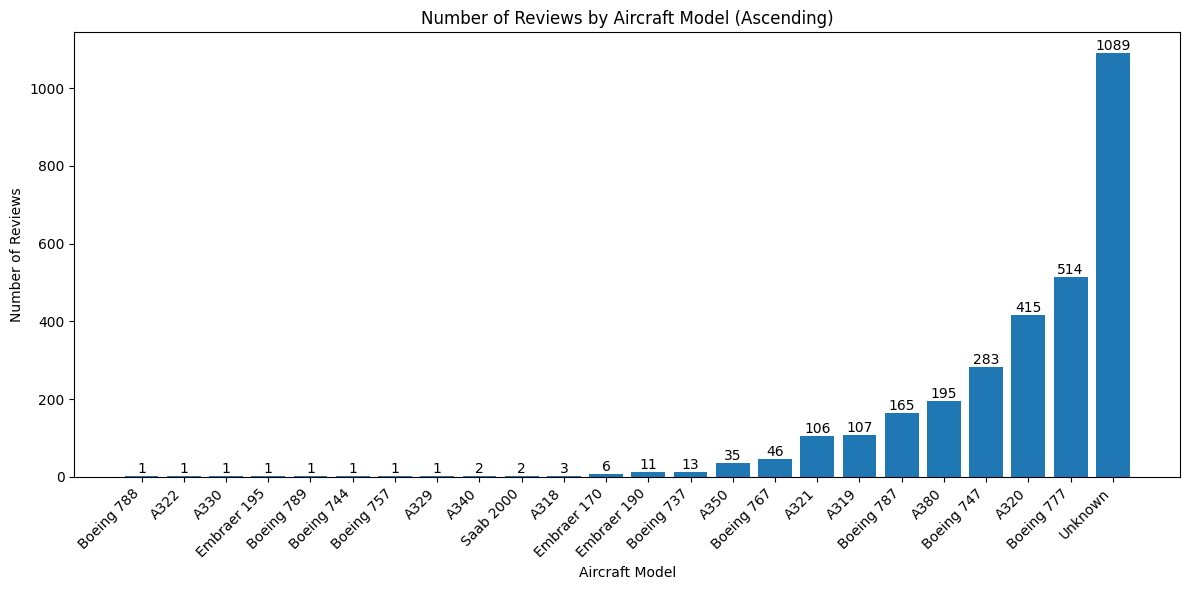

<Figure size 1200x600 with 0 Axes>

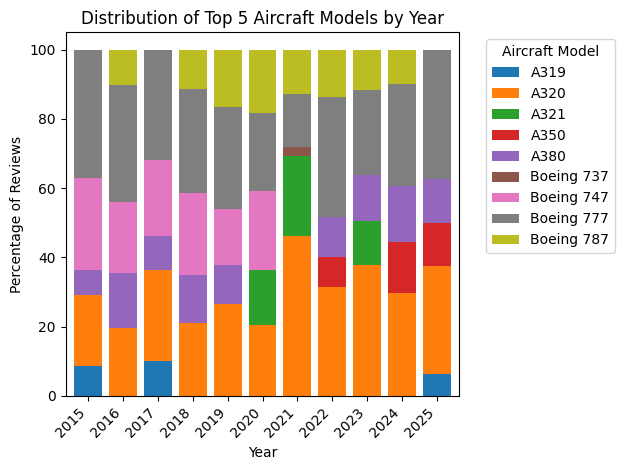

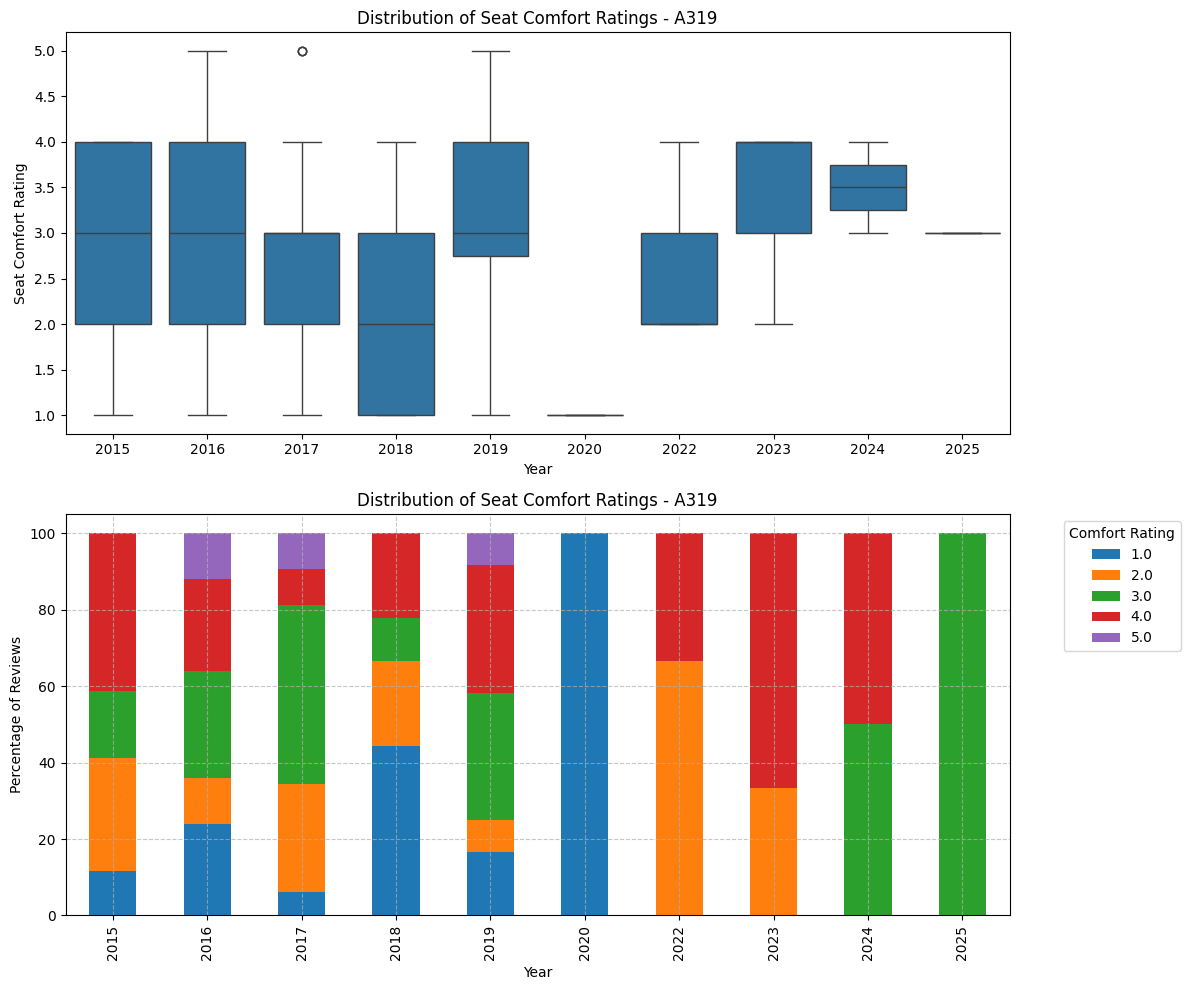

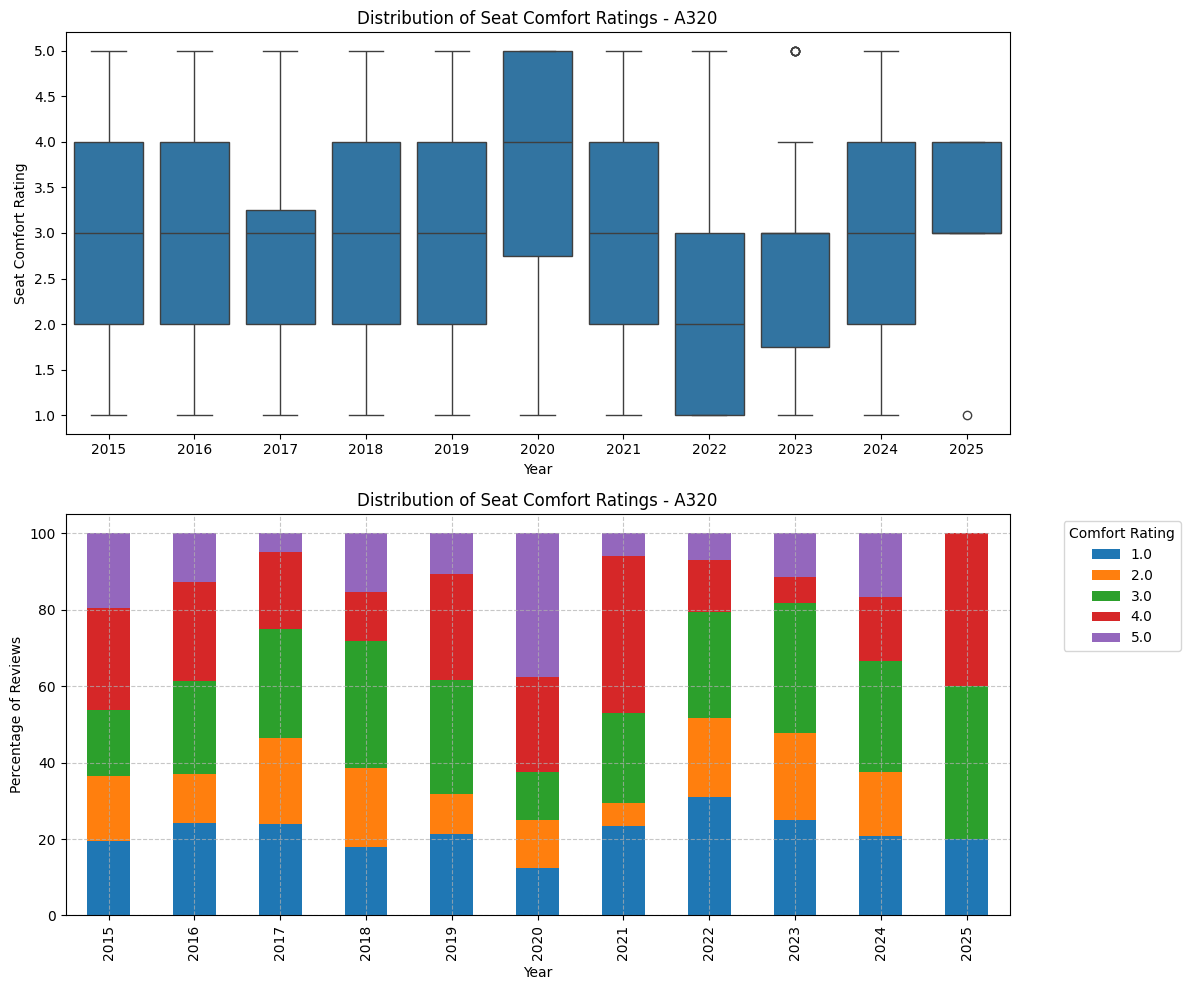

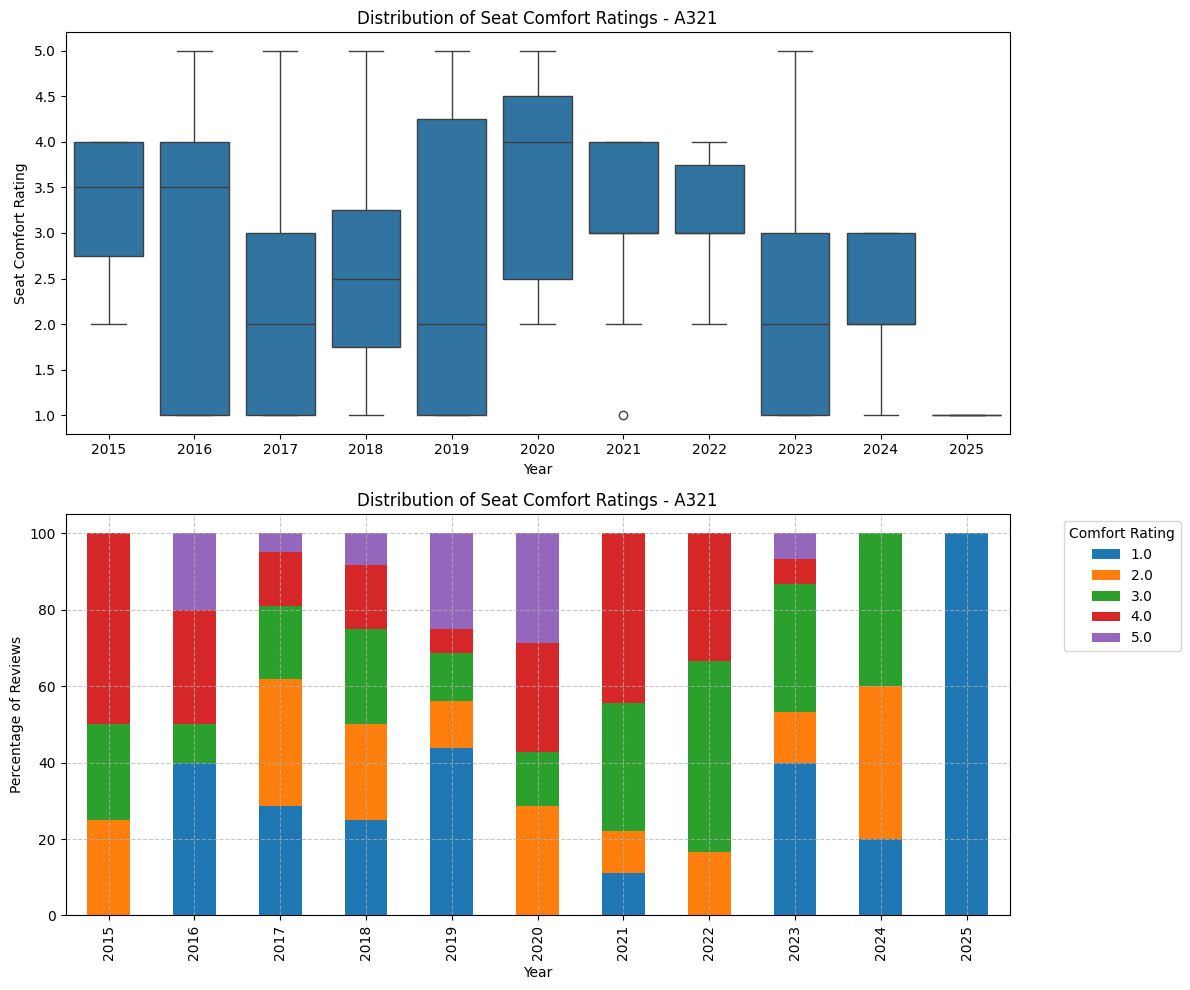

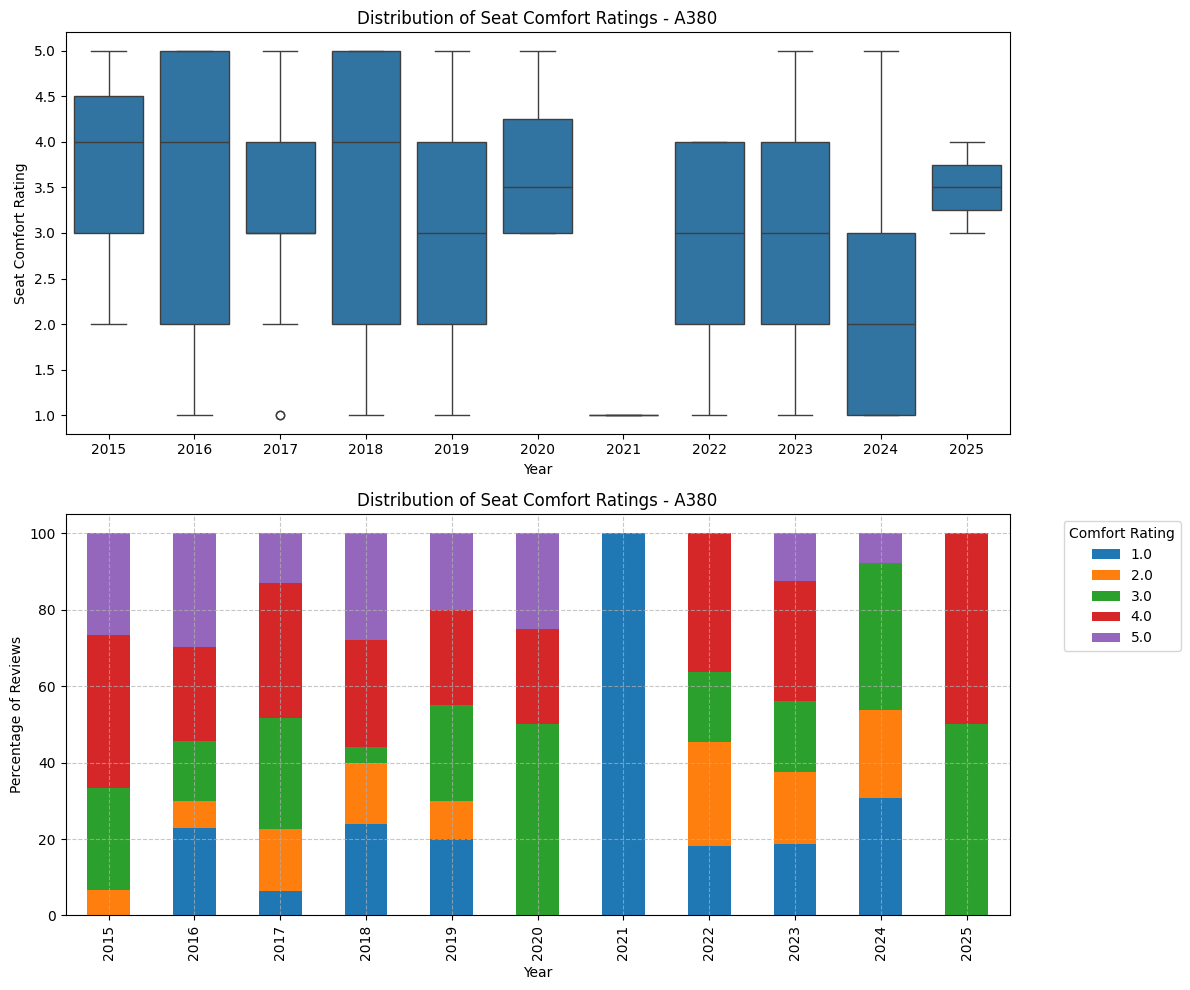

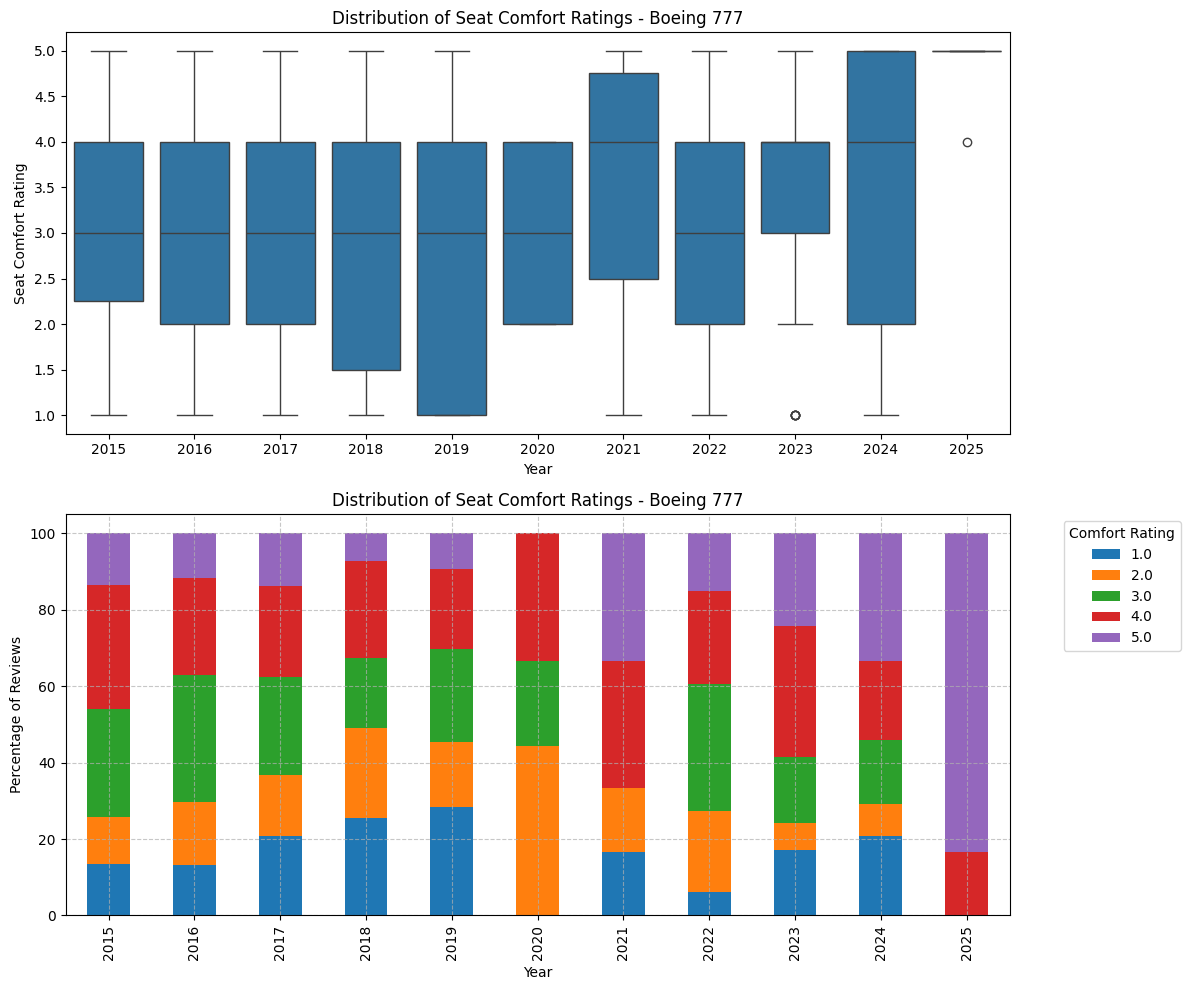

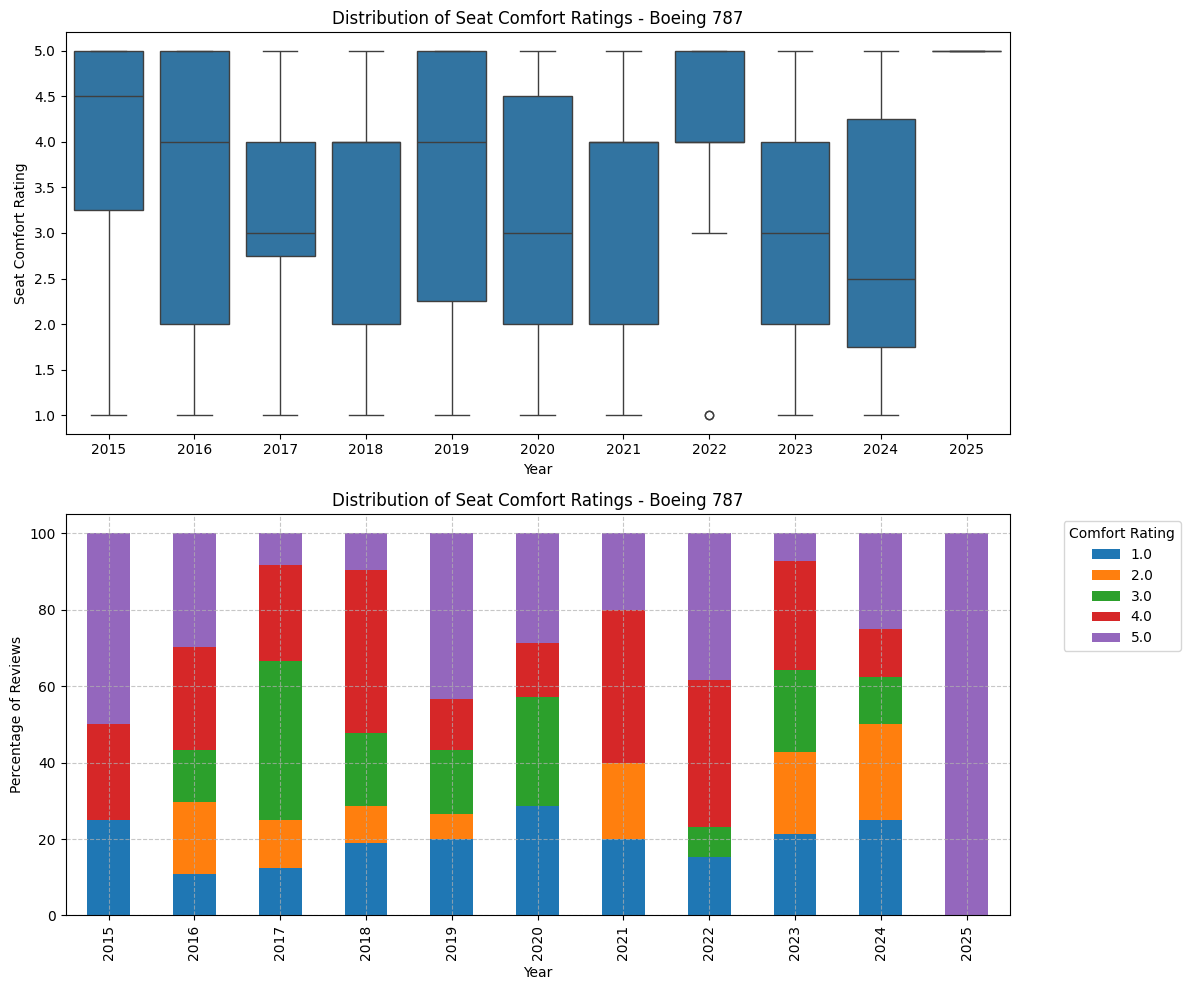

In [10]:

seat_value_aircraft = df[df['aircraft_model'].isin(['A319','A320','A321','A380', 'Boeing 777', 'Boeing 787'])].groupby("aircraft_model")["review_seat_comfort"].value_counts(normalize=True).unstack()

plt.figure(figsize=(12,6))
# Create stacked bar plot
ax = seat_value_aircraft.plot(kind='bar', stacked=True, width=0.8)

# Set plot title and labels
plt.title('Distribution of Seat Comfort Ratings by Aircraft Model')
plt.xlabel('Aircraft Model')
plt.ylabel('Percentage of Reviews')
plt.legend(title='Seat Comfort Rating',
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Sort the review counts in ascending order
review_counts = df['aircraft_model'].value_counts().sort_values()

# Create bar plot
plt.figure(figsize=(12,6))
plt.bar(review_counts.index, review_counts.values)

# Customize the plot
plt.title('Number of Reviews by Aircraft Model (Ascending)')
plt.xlabel('Aircraft Model') 
plt.ylabel('Number of Reviews')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(review_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()

# Create a dictionary to store top 5 aircraft for each year (excluding unknown)
yearly_top5 = {}
for year in df['review_year'].unique():
    year_data = df[df['review_year'] == year]
    # Filter out unknown aircraft before getting top 5
    year_data = year_data[year_data['aircraft_model'] != 'Unknown']
    yearly_top5[year] = year_data['aircraft_model'].value_counts().nlargest(5).index.tolist()

# Create a filtered dataframe with only top 5 aircraft for each year
df_filtered = pd.DataFrame()
for year in yearly_top5:
    year_data = df[df['review_year'] == year]
    year_top5 = yearly_top5[year]
    filtered_year = year_data[year_data['aircraft_model'].isin(year_top5)]
    df_filtered = pd.concat([df_filtered, filtered_year])

# Create a pivot table of aircraft percentages by year
aircraft_by_year = pd.crosstab(df_filtered['review_year'], 
                              df_filtered['aircraft_model'],
                              normalize='index') * 100

plt.figure(figsize=(12,6))

# Create stacked bar plot
ax = aircraft_by_year.plot(kind='bar', stacked=True, width=0.8)

# Set plot title and labels
plt.title('Distribution of Top 5 Aircraft Models by Year')
plt.xlabel('Year')
plt.ylabel('Percentage of Reviews')
plt.legend(title='Aircraft Model',
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

def plot_seat_comfort_by_aircraft(aircraft_model):
    # Filter data for the specified aircraft
    aircraft_data = df[df['aircraft_model'] == aircraft_model]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Distribution plot
    sns.boxplot(data=aircraft_data, x='review_year', y='review_seat_comfort', ax=ax1)
    ax1.set_title(f'Distribution of Seat Comfort Ratings - {aircraft_model}')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Seat Comfort Rating')
    
    # Plot 2: Stacked bar plot
    # Calculate percentage distribution of ratings for each year
    yearly_dist = pd.crosstab(aircraft_data['review_year'], 
                             aircraft_data['review_seat_comfort'],
                             normalize='index') * 100
    
    # Create stacked bar plot
    yearly_dist.plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_title(f'Distribution of Seat Comfort Ratings - {aircraft_model}')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Percentage of Reviews')
    ax2.legend(title='Comfort Rating', bbox_to_anchor=(1.05, 1))
    
    # Add grid to line plot
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage for common aircraft models
common_aircraft = ['A319', 'A320', 'A321', 'A380', 'Boeing 777', 'Boeing 787']
for aircraft in common_aircraft:
    plot_seat_comfort_by_aircraft(aircraft)


Consistently, we see the use of A319, A320, A321, A380, Boeing 777, and Boeing 787. Let's explore the rating among these aircrafts.